In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import pandas as pd
import configs
import torch
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform

from src.utils import find_ckpt_file, convert_to_tensor
import h5py
import random
from src.evals.eval_trees import EvalTrees, EvalCntrees
from copy import copy

# Load Model

In [2]:
corr = 0.25

In [3]:
model_name, path_to_pkl, eval_dset_path = configs.get_model_paths(corr, "tree_maze_big_pretraining")
model_name, path_to_pkl, eval_dset_path = configs.get_model_paths(corr, "tree_maze")

epoch=25-val_loss=0.000326.ckpt
epoch=35-val_loss=0.000347.ckpt


In [4]:
# Extract parameters using regex
import re

n_embd = int(re.search(r'embd(\d+)', model_name).group(1))
n_layer = int(re.search(r'layer(\d+)', model_name).group(1))
n_head = int(re.search(r'head(\d+)', model_name).group(1))
dropout = float(re.search(r'drop(\d*\.?\d*)', model_name).group(1))

# Extract correlation and state_dim from eval dataset path
state_dim = int(re.search(r'state_dim(\d+)', eval_dset_path).group(1))

model_config = {
    "n_embd": n_embd,
    "n_layer": n_layer,
    "n_head": n_head,
    "state_dim": 10,
    "action_dim": 4,
    "dropout": dropout,
    "train_on_last_pred_only": False,
    "test": True,
    "name": "transformer_end_query",
    "optimizer_config": None,
    "linear_attention": False,
}

In [5]:
from src.models.transformer_end_query import Transformer
model_config['initialization_seed'] = 1
model = Transformer(**model_config)
checkpoint = torch.load(path_to_pkl)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to('cuda')


/tmp/ipykernel_1763310/1990159134.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_to_pkl)


# Load Dataset and Create Environment

In [6]:
n_eval_envs = 50

is_h5_file = eval_dset_path.endswith('.h5')
if is_h5_file:
    eval_trajs = h5py.File(eval_dset_path, 'r')
    traj_indices = list(eval_trajs.keys())
    n_eval_envs = min(n_eval_envs, len(traj_indices))
    random.seed(0)
    traj_indices = random.sample(traj_indices, n_eval_envs)
    random.seed()
    eval_trajs = [eval_trajs[i] for i in traj_indices]
else:  # Pickle file
    with open(eval_dset_path, 'rb') as f:
        eval_trajs = pickle.load(f)
    n_eval_envs = min(n_eval_envs, len(eval_trajs))
    random.seed(0)
    eval_trajs = random.sample(eval_trajs, n_eval_envs)
    random.seed()


In [7]:
def run_model(traj, model, state_features, seq_length):
    hidden_states = [[] for _ in range(model.n_layer)]
    
    for state_feature in state_features: 
        batch = {
            'context_states': convert_to_tensor([np.array(traj['context_states'])]),
            'context_actions': convert_to_tensor([np.array(traj['context_actions'])]),
            'context_next_states': convert_to_tensor([np.array(traj['context_next_states'])]),
            'context_rewards': convert_to_tensor([np.array(traj['context_rewards'])[:, None]]),
            'query_states': convert_to_tensor([np.array(state_feature)]),
            }
        batch['zeros'] = torch.zeros(1, 10 ** 2 + 4 + 1).float()
        for k in batch.keys():
            if 'context' in k:
                batch[k] = batch[k][:,:seq_length]
            batch[k] = batch[k].to(model.device)
        model.save_activations = True
        with torch.no_grad():
            out = model(batch)
        _hidden_states = model.activations['hidden_states'][1:] # Tuple over layers
        for i_layer in range(model.n_layer):
            hidden_states[i_layer].append(_hidden_states[i_layer].cpu().numpy().squeeze()[-1])
    return hidden_states

In [8]:
def get_node_and_representation(traj, env, model):
    nodes = []
    hidden_states = []
    seq_lengths = []
    state_features = []
    state_features = list(env.node_map.keys())

    _nodes = [] 
    for state_feature in state_features:
        _nodes.append(str(env.node_map[state_feature]))
    for seq_length in [1, 25, 50, 75, 100, 250, 500, 750, 1000, 1100, 1200, 1300, 1400, 1500, 1600]:
        _hidden_states = run_model(traj, model, state_features, seq_length=seq_length)
        for l in range(model.n_layer):
            if len(_hidden_states[l]) != len(_nodes):
                print(l)
                print(len(_hidden_states[l]), len(_nodes))
                import pdb; pdb.set_trace()
        nodes.append(_nodes)
        hidden_states.append(_hidden_states)
        seq_lengths.append(seq_length)

    return nodes, hidden_states, seq_lengths

In [9]:
results = {
    'nodes': [],
    'hidden_states': [],
    'model_layer': [], 
    'context_length': [],
    'env': []
}

for i_eval, traj in enumerate(eval_trajs[:10]):
    env_config = {
        'max_layers': 7,
        'horizon': 1600,
        'branching_prob': 1.0,
        'node_encoding_corr': corr,
        'state_dim': state_dim,
        'initialization_seed': np.array(traj['initialization_seed']).item()
    }
    env = EvalCntrees().create_env(env_config, np.array(traj['goal']), i_eval)
    nodes, hidden_states, context_lengths = get_node_and_representation(traj, env, model)
    for _nodes, _hidden_states, _context_length in zip(nodes, hidden_states, context_lengths):
        for i_layer, model_layer_hidden_states in enumerate(_hidden_states):
            results['nodes'].extend(_nodes)
            results['hidden_states'].extend(model_layer_hidden_states)
            results['model_layer'].extend([i_layer] * len(_nodes))
            results['context_length'].extend([_context_length] * len(_nodes))
            results['env'].extend([i_eval] * len(_nodes))

`GPT2SdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [10]:
df = pd.DataFrame(results)

In [11]:
same_node = {
    'sim': [],
    'model_layer': [],
    'context_length': [],
    'comparison_node_layer': []
}
diff_node = {
    'sim': [],
    'model_layer': [],
    'context_length': [],
    'comparison_node_layer': []
}

for context_length in df['context_length'].unique():
    context_length_df = df[df['context_length'] == context_length]
    for i_layer in context_length_df['model_layer'].unique():
        layer_df = context_length_df[context_length_df['model_layer'] == i_layer]
        for node in layer_df['nodes'].unique():
            node_df = layer_df[layer_df['nodes'] == node]
            other_node_df = layer_df[layer_df['nodes'] != node]

            node_envs = node_df['env'].to_numpy()
            other_node_envs = other_node_df['env'].to_numpy()
            stacked_envs = np.concatenate((node_envs, other_node_envs))

            node_hidden_states = np.stack(node_df['hidden_states'].to_numpy())
            other_node_hidden_states = np.stack(other_node_df['hidden_states'].to_numpy())

            n_same_node = node_hidden_states.shape[0]
            stacked_reprs = np.vstack((node_hidden_states, other_node_hidden_states))
            cc = np.corrcoef(stacked_reprs)
            for i in range(n_same_node):
                for j in range(i+1, n_same_node):
                    if stacked_envs[i] == stacked_envs[j]:
                        continue
                    same_node['sim'].append(cc[i, j])
                    same_node['model_layer'].append(i_layer)
                    same_node['context_length'].append(context_length)
                    same_node['comparison_node_layer'].append(int(node[1]))
            for i in range(n_same_node):
                for j in range(i+1, n_same_node):
                    _j = j + n_same_node
                    if stacked_envs[i] == stacked_envs[_j]:
                        continue
                    diff_node['sim'].append(cc[i, _j])
                    diff_node['model_layer'].append(i_layer)
                    diff_node['context_length'].append(context_length)
                    diff_node['comparison_node_layer'].append(int(node[1]))

In [12]:
same_node_df = pd.DataFrame(same_node)
diff_node_df = pd.DataFrame(diff_node)


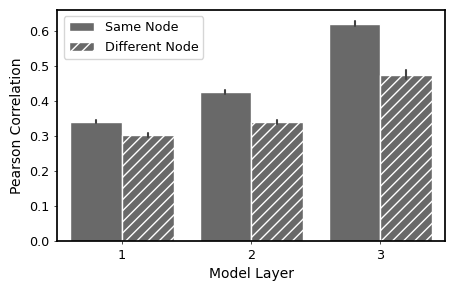

In [13]:
_same_node_df = same_node_df[same_node_df['context_length'] == 1000]
_diff_node_df = diff_node_df[diff_node_df['context_length'] == 1000]
fig, ax = plt.subplots(figsize=(5, 3))
ax = sns.barplot(
    data=pd.concat([
        _same_node_df.assign(type='Same Node'),
        _diff_node_df.assign(type='Different Node')
    ]),
    x='model_layer', y='sim', hue='type', ax=ax, 
    )

for i, bar in enumerate(ax.patches):
    if bar.get_facecolor() == (0.7642156862745098, 0.5318627450980391, 0.12598039215686285, 1):  # C1 color
        bar.set_hatch('///')
    bar.set_facecolor('dimgray')
plt.ylabel('Pearson Correlation')
plt.xlabel('Model Layer')
plt.xticks(np.arange(model.n_layer), np.arange(model.n_layer)+1)
plt.legend()
plt.show()



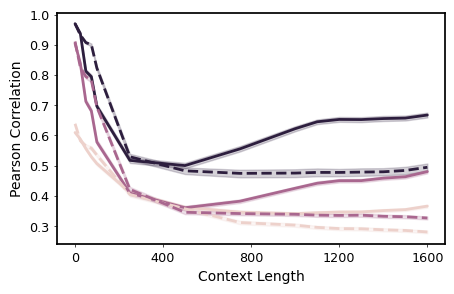

In [14]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.lineplot(
    data=same_node_df[same_node_df['context_length'] <= 1600],
    x='context_length', y='sim', hue='model_layer',
    linewidth=2, legend=False, ax=ax)
sns.lineplot(
    data=diff_node_df[diff_node_df['context_length'] <= 1600],
    x='context_length', y='sim', hue='model_layer',
    linewidth=2, legend=False, ax=ax, linestyle='--')
plt.ylabel('Pearson Correlation')
plt.xlabel('Context Length')
plt.xticks(np.arange(0, 2000, 400))
plt.show()


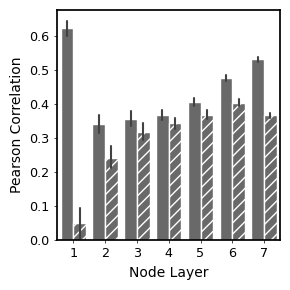

In [30]:
_same_node_df = same_node_df[same_node_df['context_length'] == 1200]
_diff_node_df = diff_node_df[diff_node_df['context_length'] == 1200]

fig, ax = plt.subplots(figsize=(3,3))
ax = sns.barplot(
    data=pd.concat([
        _same_node_df.assign(type='Same Node'),
        _diff_node_df.assign(type='Different Node')
    ]),
    x='comparison_node_layer', y='sim', hue='type', ax=ax, 
    legend=None
    )

for i, bar in enumerate(ax.patches):
    if bar.get_facecolor() == (0.7642156862745098, 0.5318627450980391, 0.12598039215686285, 1):  # C1 color
        bar.set_hatch('///')
    bar.set_facecolor('dimgray')
    
# Set figure DPI higher for SVG export
plt.rcParams['svg.fonttype'] = 'none'  # Ensure text remains as text in SVG
plt.ylabel('Pearson Correlation')
plt.xlabel('Node Layer')
plt.xticks(np.arange(7), np.arange(7)+1)
plt.tight_layout()
plt.savefig('figs/cross_context_by_layer.pdf', dpi=300)
plt.show()


# fig, ax = plt.subplots(figsize=(4,3))
# ax = sns.barplot(
#     data=pd.concat([
#         _same_node_df.assign(type='Same Node'),
#         _diff_node_df.assign(type='Different Node')
#     ]),
#     x='comparison_node_layer', y='sim', hue='type', ax=ax, 
#     legend=None
#     )

# for i, bar in enumerate(ax.patches):
#     if bar.get_facecolor() == (0.7642156862745098, 0.5318627450980391, 0.12598039215686285, 1):  # C1 color
#         bar.set_hatch('///')
#     bar.set_facecolor('dimgray')
# plt.ylabel('Pearson Correlation')
# plt.xlabel('Node Layer')
# plt.xticks(np.arange(7), np.arange(7)+1)
# plt.tight_layout()
# plt.savefig('figs/cross_context_by_layer.svg', dpi=300)
# plt.show()